In [1]:
import os
from graph_partitioning import GraphPartitioning, utils

pwd = %pwd

config = {

    "DATA_FILENAME": os.path.join(pwd, "data", "oneshot_fennel_weights.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "SCOTCH",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "FENNEL",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd, "data", "simulated_arrival.txt"),

    # File containing the geographic location of each node.
    "POPULATION_LOCATION_FILE": os.path.join(pwd, "data", "population_location.csv"),

    # Number of shelters
    "num_partitions": 4,

    # The number of iterations when making prediction model
    "num_iterations": 10,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.10,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 100,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,


    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": True,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": True,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    
    # Path to the scotch shared library
    "SCOTCH_LIB_PATH": "/usr/local/lib/libscotch.so",

    "SCOTCH_PYLIB_REL_PATH": os.path.join(pwd, "..", "csap-graphpartitioning", "src", "python")
}

gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

import pandas as pd
cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY"]

Populating the interactive namespace from numpy and matplotlib


In [2]:
gp.load_network()

Graph loaded...
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 2939
Average degree:   5.8780
Graph is undirected


In [3]:
gp.init_paritioner()

FENNEL partitioner loaded for making shelter assignments.
SCOTCH partitioner loaded for generating PREDICTION MODEL.


# Prediction Model

In [4]:
m = gp.prediction_model()

PREDICTION MODEL
----------------


Assignments:
[ 3  1  2  0  0  0  0  2  3  1  3  1  0  1  1  0  3  2  0  0  1  2  3  2  1  3  2  3  0  1  0  2  0  3  3  0  1  3  2  1  2  1  3  1  1  2  1  3  3  2  0  3  3  2  3  2  0  0  1  0  2  0  1  2  1  1  3  2  1  3  1  0  0  1  3  2  0  3  3  0  2  3  0  2  1  3  1  0  1  0  0  3  3  0  0  2  3  2  1  3  1  0  2  0  1  1  1  0  1  3  2  0  2  3  0  1  3  1  0  2  1  1  0  0  0  3  0  2  0  1  0  3  1  3  3  1  1  2  3  3  1  2  2  0  2  1  3  2  0  3  0  1  1  0  1  2  1  2  3  0  1  1  0  0  1  3  1  3  3  1  3  1  2  3  2  1  1  0  0  1  2  0  1  2  3  1  2  1  0  2  3  2  3  0  0  1  3  0  1  0  2  3  3  1  0  2  2  1  0  2  3  3  3  0  0  0  2  0  2  2  1  1  1  1  2  2  2  0  0  0  1  2  3  3  3  1  3  0  0  1  2  2  0  3  3  2  2  1  0  1  1  3  0  3  3  3  3  2  3  0  3  3  0  2  3  1  0  2  2  3  3  3  1  3  1  2  0  1  2  1  2  3  3  2  1  1  0  2  0  0  0  1  0  1  2  3  2  0  3  1  0  0  3  2  1  0  1  2  1  1  2  2  0  2  3  0  3

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY
1  0.052   0.021436         63                107    0.727347


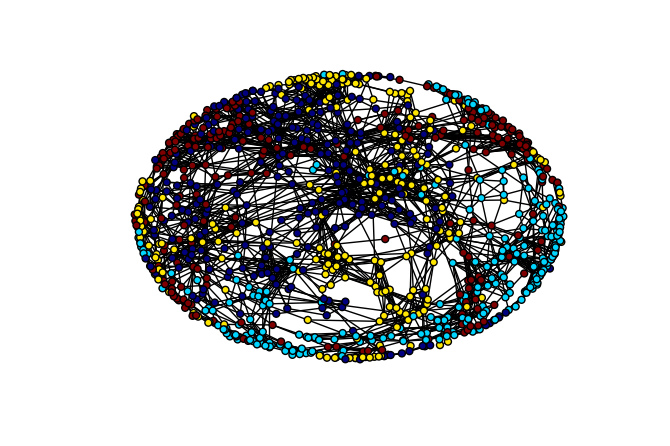

In [5]:
import networkx as nx

rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

part = dict(zip(gp.G.nodes(), gp.assignments))
values = [part.get(node) for node in gp.G.nodes()]
nx.draw_spring(gp.G, cmap=plt.get_cmap('jet'), node_color=values, node_size=25, with_labels=False)

# Assign Cut Off

In [6]:
gp.assign_cut_off()

Assign first 100 arrivals using prediction model, then discard

WASTE		CUT RATIO	EDGES CUT	TOTAL COMM VOLUME
8.00000		0.1687648860	496		459			0.014346145239004673

Assignments:
[-1  1  2  0 -1  0  0 -1 -1 -1  3 -1  0  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  0 -1 -1  2 -1  3 -1 -1  1 -1 -1  1 -1  1 -1  1 -1  2  1 -1  3  2  0 -1 -1 -1 -1  2  0 -1  1  0 -1 -1 -1 -1  1 -1  3  2  1  3  1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1  1 -1  1 -1 -1  0  0  3 -1  0  0 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  0 -1  3 -1  0 -1 -1 -1  1  3  1 -1 -1  1 -1  0  0 -1  3 -1 -1  0  1  0 -1  1 -1 -1 -1  1 -1  3  3  1  2  2 -1 -1  1 -1  2 -1 -1 -1 -1  1  0  1  2  1 -1 -1 -1  1  1  0 -1  1  3  1  3 -1 -1 -1  1 -1  3 -1  1 -1 -1 -1  1 -1  0 -1 -1  3  1 -1  1 -1 -1 -1 -1 -1 -1  0  1 -1 -1  1  0 -1 -1 -1  1  0 -1 -1  1 -1 -1 -1 -1  3  0 -1  0 -1  0 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

# Run Simulation

In [7]:
m = gp.batch_arrival()

Assigning in batches of 100
--------------------------------


Assignments:
[-1  1  2  0 -1  0  0 -1 -1 -1  3 -1  0  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  0 -1 -1  2 -1  3 -1 -1  1 -1 -1  1 -1  1 -1  1 -1  2  1 -1  3  2  0 -1 -1 -1 -1  2  0 -1  1  0 -1 -1 -1 -1  1 -1  3  2  1  3  1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1  1 -1  1 -1 -1  0  0  3 -1  0  0 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  0 -1  3 -1  0 -1 -1 -1  1  3  1 -1 -1  1 -1  0  0 -1  3 -1 -1  0  1  0 -1  1 -1 -1 -1  1 -1  3  3  1  2  2 -1 -1  1 -1  2 -1 -1 -1 -1  1  0  1  2  1 -1 -1 -1  1  1  0 -1  1  3  1  3 -1 -1 -1  1 -1  3 -1  1 -1 -1 -1  1 -1  0 -1 -1  3  1 -1  1 -1 -1 -1 -1 -1 -1  0  1 -1 -1  1  0 -1 -1 -1  1  0 -1 -1  1 -1 -1 -1 -1  3  0 -1  0 -1  0 -1 -1  1  1  1  1 -1 -1 -1  0 -1 -1  2 -1 -1  3  2  2  2  0 -1  2 -1 -1 -1 -1 -1 -1 -1  2  2  3 -1  3  0 -1  3  2 -1 -1 -1 -1  2 -1  0 -1 -1  1  2  3 -1 -1 -1 -1 -1 -1  2 -1 -1  1  3 -1  2  3  3 -1  1 -1 -1 -1  0  0 -1 -1  0 -1 -1 -1  2  2 -1 -1 -1  3  2  3 -1 -1  1 -1

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY
1    5.6   0.007042          1                  2    0.045006
2    7.2   0.040752         13                 24   -0.011999
3    7.6   0.066071         37                 65    0.031502
4    7.6   0.073003         53                 81    0.022533


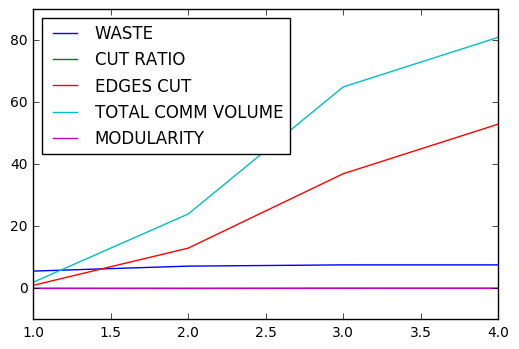

In [8]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)

df.plot()
print(df)

# Network Visual

Partition 0


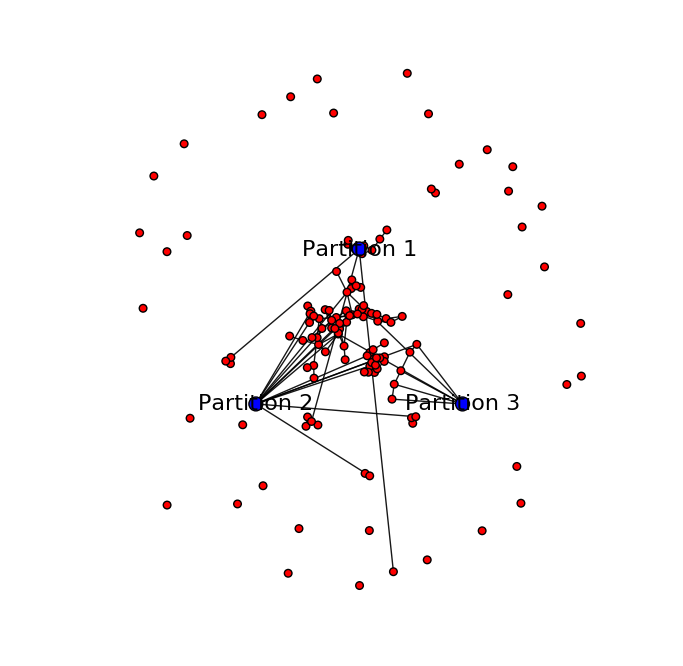

Partition 1


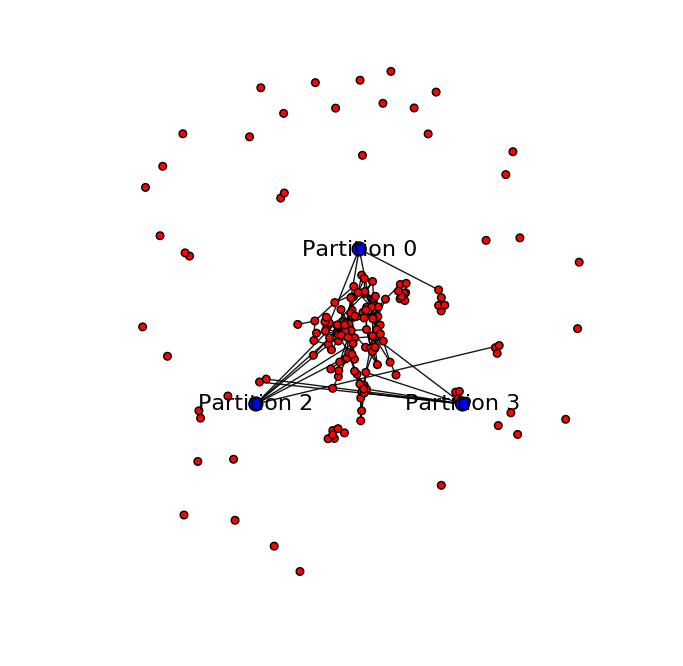

Partition 2


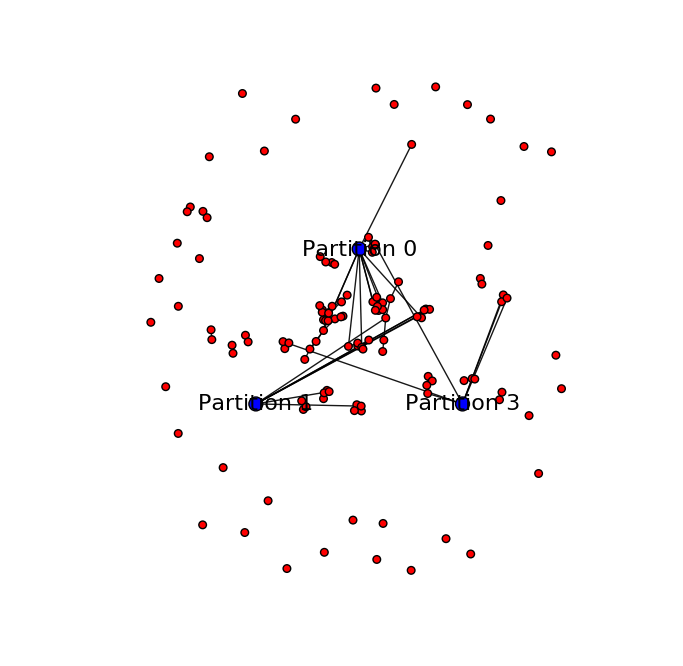

Partition 3


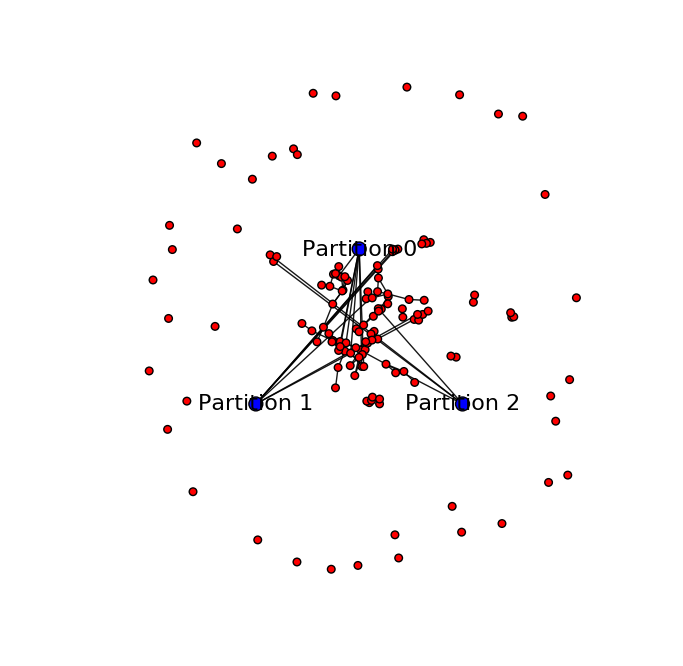

In [9]:
def draw_partition(graph, partition_nodes, fixed_positions):
    fixed_nodes = fixed_positions.keys()
    pos = nx.spring_layout(graph, k=1, iterations=10, pos=fixed_positions, fixed=fixed_nodes)
    plt.figure(figsize=(8, 8))
    plt.axis('off')

    size = [] 
    colour = []
    labels = {}
    for n in graph.nodes_iter():
        if n in partition_nodes:
            size += [100]
            colour += ['b']
            labels[n] = 'Partition ' + str(partition_nodes.index(n))
        else:
            size += [30]
            colour += ['r']

    nx.draw_networkx_nodes(graph, pos, node_size=size, node_color=colour, with_labels=False)
    nx.draw_networkx_edges(graph, pos, alpha=0.9)
    nx.draw_networkx_labels(graph, pos, labels, font_size=16, font_family='sans-serif')
    plt.show(graph)

partition_nodes = list(range(1000, 1000 + gp.num_partitions))

print('Partition 0')
fixed_positions = {1001: (0, 1), 1002: (-1, 0), 1003: (1, 0)}
part_graph = utils.squash_partition(gp.G, partition_nodes, 0, gp.assignments)
draw_partition(part_graph, partition_nodes, fixed_positions)

print('Partition 1')
fixed_positions = {1000: (0, 1), 1002: (-1, 0), 1003: (1, 0)}
part_graph = utils.squash_partition(gp.G, partition_nodes, 1, gp.assignments)
draw_partition(part_graph, partition_nodes, fixed_positions)

print('Partition 2')
fixed_positions = {1000: (0, 1), 1001: (-1, 0), 1003: (1, 0)}
part_graph = utils.squash_partition(gp.G, partition_nodes, 2, gp.assignments)
draw_partition(part_graph, partition_nodes, fixed_positions)

print('Partition 3')
fixed_positions = {1000: (0, 1), 1001: (-1, 0), 1002: (1, 0)}
part_graph = utils.squash_partition(gp.G, partition_nodes, 3, gp.assignments)
draw_partition(part_graph, partition_nodes, fixed_positions)

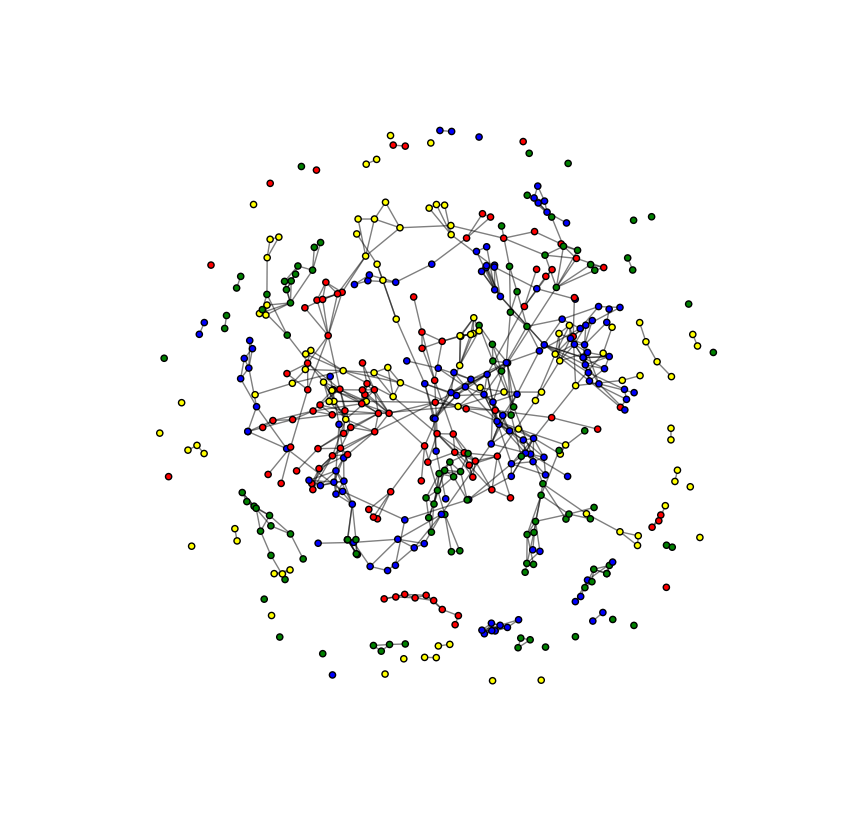

In [10]:
part = dict(zip(gp.G.nodes(), gp.assignments))
values = [part.get(node) for node in gp.G.nodes()]

pos = nx.spring_layout(gp.G, k=0.5, iterations=20)
plt.figure(figsize=(10, 10))
plt.axis('off')
colours = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}

colour = []
for n in gp.G.nodes_iter():
    colour += [colours[gp.assignments[n]]]

nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=colour, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

# Metrics

In [11]:
gp.get_metrics()

Complete graph with 1000 nodes
Writing GML file: /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-185455-all-graph.gml
Writing assignments: /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-185455-all-assignments.txt
Writing edge list (for MaxPerm): /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-185455-all-edges-maxperm.txt
Writing edge list (for OSLOM): /home/sami/repos/smbwebs/graph-partitioning/output/oneshot_fennel_weights-185455-all-edges-oslom.txt

Config
-------

file: 185455
num_partitions: 4
num_iterations: 10
prediction_model_cut_off: 0.1
one_shot_alpha: 0.5
restream_batches: 100
use_virtual_nodes: False
virtual_edge_weight: 1.0

Metrics
-------

edges_cut: 53
waste: 7.599999999999998
cut_ratio: 0.07300275482093664
communication_volume: 81
network_permanence: -0.428883
Q: -0.003216803648809664
NQ: -52.092663790515964
Qds: -0.999999999999999
intraEdges: 0.0
interEdges: 34903.846153846156
intraDensity: 